# 0 数据提取处理定义时间范围

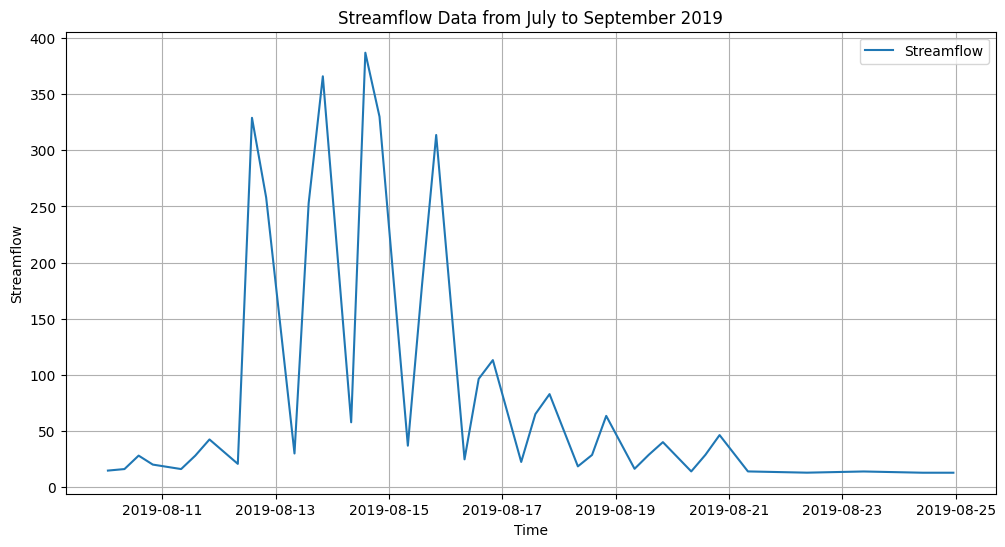

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Load the NetCDF file
file_path = 'biliu_inq_interpolated.csv'
data = pd.read_csv(file_path)

# 后续操作需要读取列名与该数据不一致这里统一进行更改
data = data.rename(columns={'TM': 'time', 'INQ': 'streamflow'})

# 填充缺失值为前后5小时的平均值
data['streamflow'] = data['streamflow'].fillna(
    data['streamflow'].rolling(window=11, min_periods=1).mean()
)

# Extracting data for the period July to September 2019
start_date = '2019-08-10'
end_date = '2019-08-25'

data['time'] = pd.to_datetime(data['time'])
streamflow_data = data[(data['time']>start_date) & (data['time']<end_date)]
streamflow_data
# Plotting the streamflow data
plt.figure(figsize=(12, 6))
plt.plot(streamflow_data['time'], streamflow_data['streamflow'].squeeze(), label='Streamflow')
plt.xlabel('Time')
plt.ylabel('Streamflow')
plt.title('Streamflow Data from July to September 2019')
plt.legend()
plt.grid(True)
plt.show()

# 1 论文算法复现

## 无迹卡尔曼滤波

In [2]:
import numpy as np

def kalman_filter(streamflow_data):
    A = np.array([[1]])  # State transition matrix
    H = np.array([[1]])  # Measurement matrix
    Q = np.array([[0.01]])  # Process noise covariance
    R = np.array([[0.01]])  # Measurement noise covariance
    X_estimated = np.array([streamflow_data[0]])  # Initial state estimate
    P_estimated = np.eye(1) * 0.01  # Initial state covariance estimate
    estimated_states = []

    for measurement in streamflow_data:
        # Prediction step
        X_predicted = A.dot(X_estimated)
        P_predicted = A.dot(P_estimated).dot(A.T) + Q

        # Update step
        measurement_residual = measurement - H.dot(X_predicted)
        S = H.dot(P_predicted).dot(H.T) + R
        K = P_predicted.dot(H.T).dot(np.linalg.inv(S))  # Kalman gain
        X_estimated = X_predicted + K.dot(measurement_residual)
        P_estimated = P_predicted - K.dot(H).dot(P_predicted)
        estimated_states.append(X_estimated.item())

    return estimated_states


## 滑动平均

In [3]:
import numpy as np

def moving_average(streamflow_data, window_size=20):
    return np.convolve(streamflow_data, np.ones(window_size)/window_size, mode='same')


## 抗差修正

In [4]:
import numpy as np
from scipy.optimize import curve_fit

def quadratic_function(x, a, b, c):
    return a * x**2 + b * x + c

def robust_fitting(streamflow_data, k=1.5):
    time_steps = np.arange(len(streamflow_data))
    params, _ = curve_fit(quadratic_function, time_steps, streamflow_data)
    smoothed_streamflow = quadratic_function(time_steps, *params)
    residuals = streamflow_data - smoothed_streamflow
    m = len(streamflow_data)
    sigma = np.sqrt(np.sum(residuals**2) / (m - 1))

    for _ in range(10):
        weights = np.where(np.abs(residuals) <= k * sigma, 1, k * sigma / np.abs(residuals))
        sigma = np.sqrt(np.sum(weights * residuals**2) / (m - 1))

    corrected_streamflow = weights * streamflow_data + (1 - weights) * smoothed_streamflow
    return corrected_streamflow


## 数据拟合

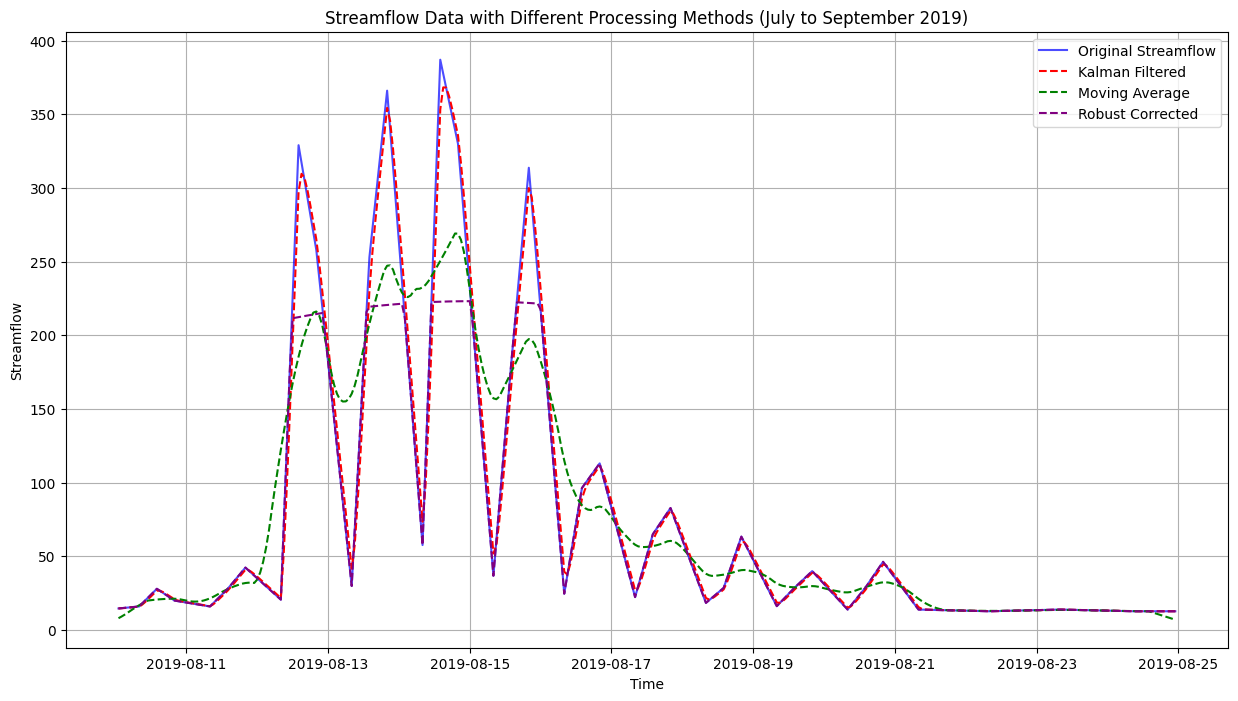

In [5]:
# 提取一维流量数据
streamflow_values = streamflow_data['streamflow'].values.squeeze()

# 卡尔曼滤波
kalman_filtered_data = kalman_filter(streamflow_values)

# 滑动平均
moving_averaged_data = moving_average(streamflow_values)

# 抗差修正
robust_corrected_data = robust_fitting(streamflow_values)

# 绘图
plt.figure(figsize=(15, 8))
plt.plot(streamflow_data['time'], streamflow_values, label='Original Streamflow', color='blue', alpha=0.7)
plt.plot(streamflow_data['time'], kalman_filtered_data, label='Kalman Filtered', color='red', linestyle='--')
plt.plot(streamflow_data['time'], moving_averaged_data, label='Moving Average', color='green', linestyle='--')
plt.plot(streamflow_data['time'], robust_corrected_data, label='Robust Corrected', color='purple', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Streamflow')
plt.title('Streamflow Data with Different Processing Methods (July to September 2019)')
plt.legend()
plt.grid(True)
plt.show()


# 2 信号方法应用处理

## 低通滤波器 可保证总量一致性

Original Total Flow: 27510.18302469136
Adjusted Filtered Total Flow: 27510.18302469136


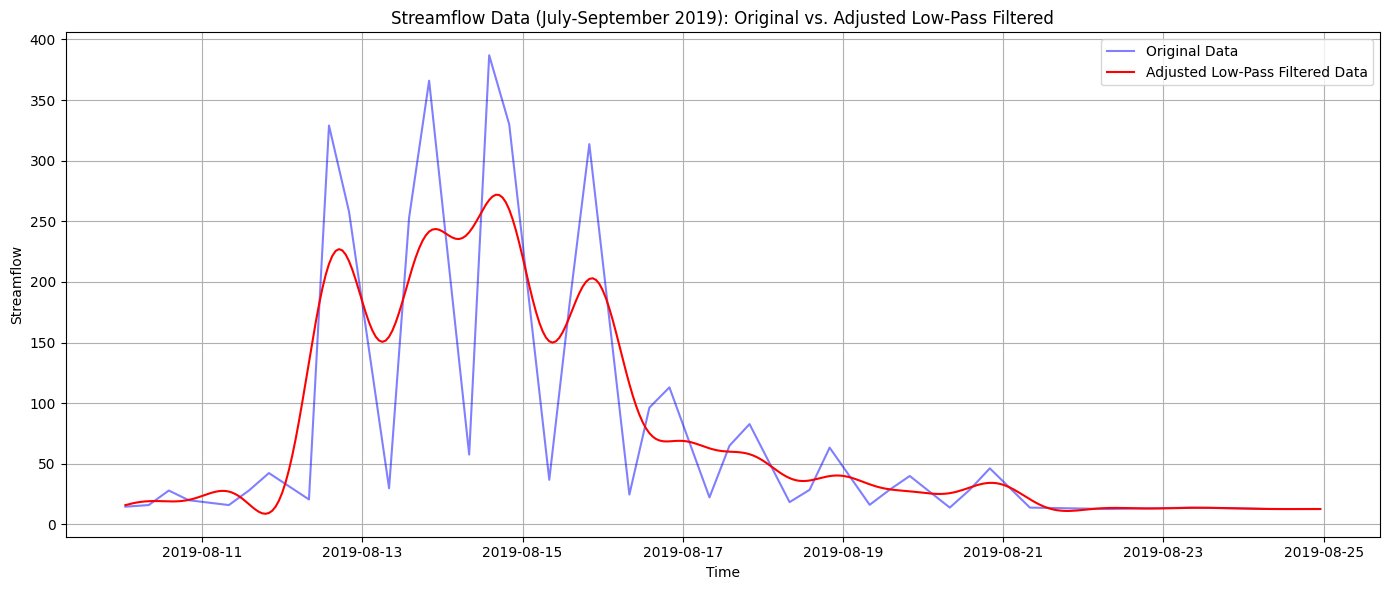

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# 定义低通滤波器函数
def apply_low_pass_filter(signal, cutoff_frequency, sampling_rate, order=5):
    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist_frequency
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# 提取的流量数据
streamflow_values = streamflow_data['streamflow'].values.squeeze()

# 应用低通滤波器
cutoff_frequency = 0.035  # 根据需要调整
sampling_rate = 1.0       # 假设数据采样率为每小时一个数据点
low_pass_filtered_signal = apply_low_pass_filter(streamflow_values, cutoff_frequency, sampling_rate)

# 矫正滤波后的信号以保持总流量一致
original_total_flow = np.sum(streamflow_values)
filtered_total_flow = np.sum(low_pass_filtered_signal)
adjustment_factor = original_total_flow / filtered_total_flow
adjusted_filtered_signal = low_pass_filtered_signal * adjustment_factor

# 确保流量数据不包含小于0的数据
adjusted_filtered_signal[adjusted_filtered_signal < 0] = 0

# 重新计算调整后的总流量
adjusted_filtered_total_flow = np.sum(adjusted_filtered_signal)

# 输出原始和调整后的总流量
print("Original Total Flow:", original_total_flow)
print("Adjusted Filtered Total Flow:", adjusted_filtered_total_flow)

# 绘制原始数据和经过调整的低通滤波处理后的数据
plt.figure(figsize=(14, 6))
plt.plot(streamflow_data['time'], streamflow_values, label='Original Data', color='blue', alpha=0.5)
plt.plot(streamflow_data['time'], adjusted_filtered_signal, label='Adjusted Low-Pass Filtered Data', color='red')
plt.xlabel('Time')
plt.ylabel('Streamflow')
plt.title('Streamflow Data (July-September 2019): Original vs. Adjusted Low-Pass Filtered')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 三次样条插值（纯数学实现）可保证总量一致性

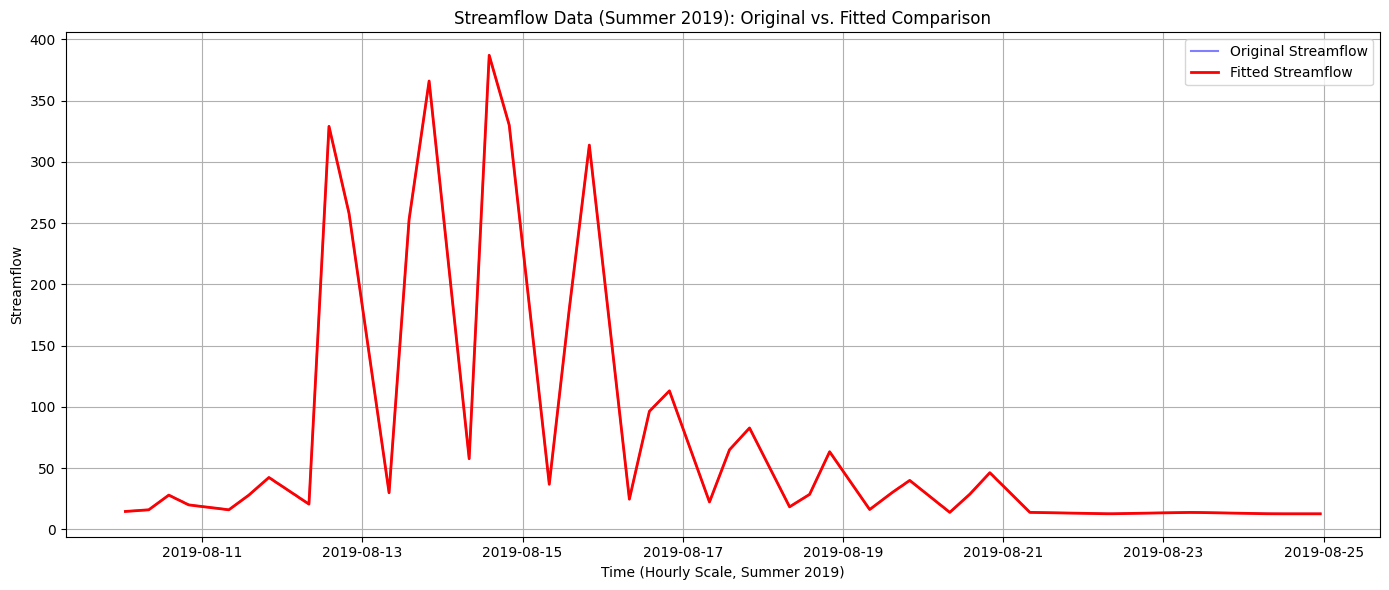

Original Total Flow: 27510.18302469136
Fitted Total Flow: 27510.183024691352


In [7]:
from scipy.interpolate import UnivariateSpline
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

def calculate_total_flow(data):
    """计算给定数据的总流量。"""
    return np.sum(data)

def adjust_flow_volume(original_signal, filtered_signal):
    """调整滤波信号的总流量以匹配原始信号的总流量。"""
    original_total_flow = calculate_total_flow(original_signal)
    filtered_total_flow = calculate_total_flow(filtered_signal)
    scale_factor = original_total_flow / filtered_total_flow
    adjusted_filtered_signal = filtered_signal * scale_factor
    return adjusted_filtered_signal, scale_factor
# 定义三次样条拟合和调整总流量的函数
def spline_fitting_with_volume_adjustment(signal, time_index, smoothing_factor=0.1):
    # 三次样条拟合
    spline = UnivariateSpline(time_index, signal, s=smoothing_factor)

    # 计算拟合曲线的值
    fitted_signal = spline(time_index)

    # 调整拟合信号的总流量以匹配原始信号的总流量
    adjusted_fitted_signal, _ = adjust_flow_volume(signal, fitted_signal)
    
    return adjusted_fitted_signal, spline

# 提取的流量数据
streamflow_values = streamflow_data['streamflow'].values.squeeze()

# 使用三次样条拟合进行数据处理
fitted_signal, spline_function = spline_fitting_with_volume_adjustment(
    streamflow_values, np.arange(len(streamflow_values)))

# 绘制原始数据和拟合结果的对比图
plt.figure(figsize=(14, 6))
plt.plot(streamflow_data['time'], streamflow_values, label='Original Streamflow', color='blue', alpha=0.5)
plt.plot(streamflow_data['time'], fitted_signal, label='Fitted Streamflow', color='red', linewidth=2)
plt.xlabel('Time (Hourly Scale, Summer 2019)')
plt.ylabel('Streamflow')
plt.title('Streamflow Data (Summer 2019): Original vs. Fitted Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 显示图表
plt.show()

# 输出原始和拟合后的流量总量，确认是否一致
original_total_flow = np.sum(streamflow_values)
fitted_total_flow = np.sum(fitted_signal)
print("Original Total Flow: " + str(original_total_flow))
print("Fitted Total Flow: " + str(fitted_total_flow))


## 傅里叶变换（连续三次）可保证总量一致性

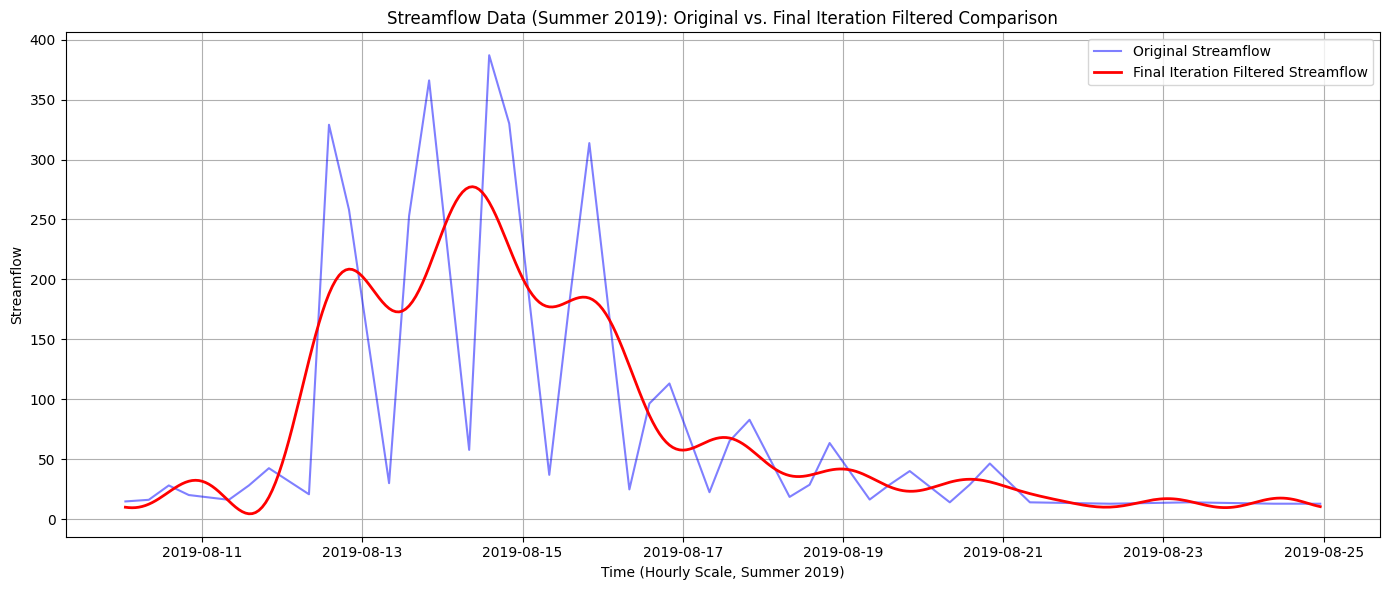

Original Total Flow: 27510.18302469136
Transformed Total Flow: 27510.18302469136


In [8]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import xarray as xr

# 先定义四个核心函数
def calculate_total_flow(data):
    """计算给定数据的总流量。"""
    return np.sum(data)

def adjust_flow_volume(original_signal, filtered_signal):
    """调整滤波信号的总流量以匹配原始信号的总流量。"""
    original_total_flow = calculate_total_flow(original_signal)
    filtered_total_flow = calculate_total_flow(filtered_signal)
    scale_factor = original_total_flow / filtered_total_flow
    adjusted_filtered_signal = filtered_signal * scale_factor
    return adjusted_filtered_signal, scale_factor

def non_negative_adjustment(signal):
    """将信号中的负值调整为零。"""
    adjusted_signal = np.where(signal < 0, 0, signal)
    return adjusted_signal

def fourier_analysis_and_filtering(signal, time_step, cutoff_frequency):
    """执行傅里叶变换和频率过滤，然后执行逆变换。"""
    n = len(signal)
    yf = fft(signal)
    xf = fftfreq(n, d=time_step)
    yf_filtered = yf.copy()
    yf_filtered[np.abs(xf) > cutoff_frequency] = 0
    filtered_signal = ifft(yf_filtered)
    return filtered_signal.real

# 现在定义迭代傅里叶滤波函数，包括非负约束和流量调整
def iterative_fourier_filtering_with_volume_and_non_negative_adjustment(signal, iterations=3, cutoff_frequency=0.1, time_step=1.0):
    filtered_signals = []
    current_signal = signal.copy()

    for _ in range(iterations):
        # 执行傅里叶分析和滤波
        filtered_signal = fourier_analysis_and_filtering(current_signal, time_step, cutoff_frequency)
        
        # 应用非负约束
        non_negative_signal = non_negative_adjustment(filtered_signal)
        
        # 调整滤波信号的流量总量
        adjusted_filtered_signal, _ = adjust_flow_volume(signal, non_negative_signal)
        
        # 保存调整后的信号
        filtered_signals.append(adjusted_filtered_signal)
        
        # 更新当前信号为下一次迭代做准备
        current_signal = adjusted_filtered_signal

    return filtered_signals

# 提取的流量数据
streamflow_values = streamflow_data['streamflow'].values.squeeze()

# 执行迭代滤波处理
filtered_signals = iterative_fourier_filtering_with_volume_and_non_negative_adjustment(
    streamflow_values, iterations=3, cutoff_frequency=0.03, time_step=1.0)

# 绘制原始数据和最终滤波结果的对比图
plt.figure(figsize=(14, 6))
plt.plot(streamflow_data['time'], streamflow_values, label='Original Streamflow', color='blue', alpha=0.5)
plt.plot(streamflow_data['time'], filtered_signals[-1], label='Final Iteration Filtered Streamflow', color='red', linewidth=2)
plt.xlabel('Time (Hourly Scale, Summer 2019)')
plt.ylabel('Streamflow')
plt.title('Streamflow Data (Summer 2019): Original vs. Final Iteration Filtered Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 输出原始和最终的流量总量，确认是否一致
original_total_flow = calculate_total_flow(streamflow_values)
final_filtered_total_flow = calculate_total_flow(filtered_signals[-1])
print("Original Total Flow: " + str(original_total_flow))
print("Transformed Total Flow: " + str(final_filtered_total_flow))

# 保存迭代滤波结果到CSV文件
filtered_signals_df = pd.DataFrame({'Time': streamflow_data['time'].values})
for i, filtered_signal in enumerate(filtered_signals, 1):
    filtered_signals_df[f'Streamflow_Iteration_{i}'] = filtered_signal
csv_file_path = 'filtered_signals.csv'
filtered_signals_df.to_csv(csv_file_path, index=False)

## Morl小波变换

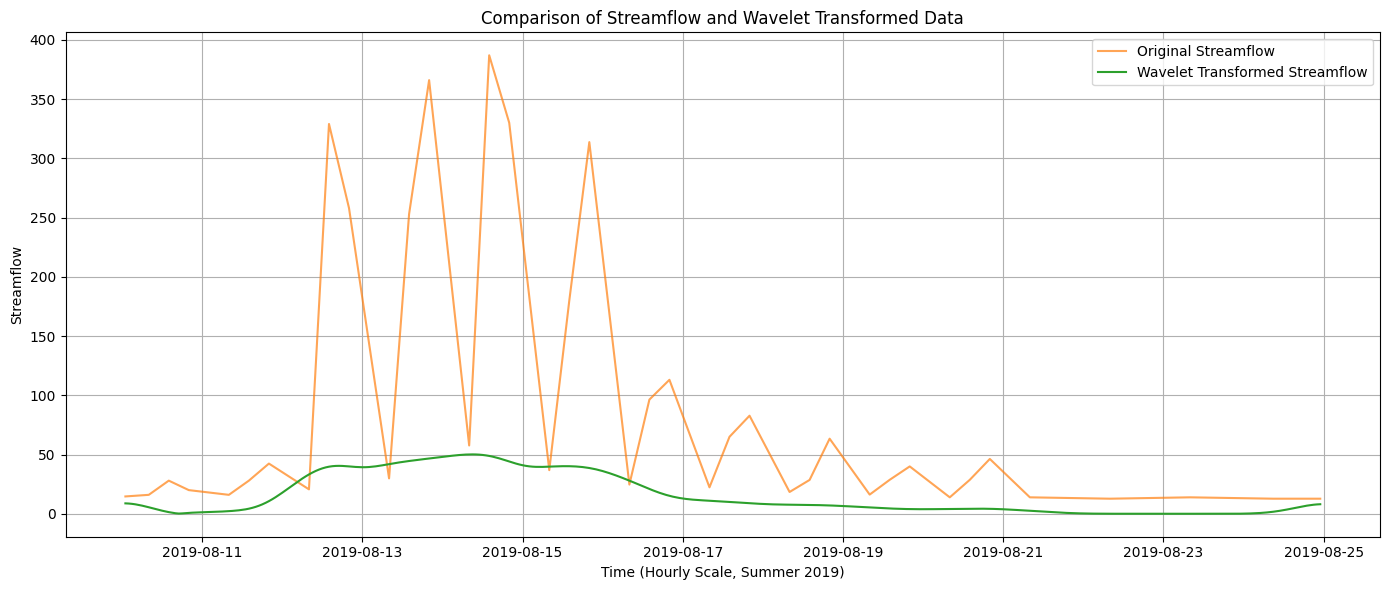

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import cwt, morlet

# 连续小波变换函数
def perform_cwt(data, wavelet_func, widths):
    cwtmatr = cwt(data, wavelet_func, widths)
    return np.abs(cwtmatr)

# 小波分析和绘图函数
def wavelet_analysis_and_plot(streamflow_data, wavelet='morl', save_path=None):
    # 提取的流量数据
    streamflow_values = streamflow_data['streamflow'].values.squeeze()
    
    # 连续小波变换
    widths = np.arange(1, 31)
    streamflow_cwt = perform_cwt(streamflow_values, morlet, widths)
    cwt_row = streamflow_cwt[10, :]  # 选取特定行

    # 保存拟合数据
    if save_path:
        fit_data = pd.DataFrame({'Time': streamflow_data['time'].values, 
                                 'Original_Streamflow': streamflow_values, 
                                 'Wavelet_Streamflow': cwt_row})
        fit_data.to_csv(save_path, index=False)

    # 绘制图表
    plt.figure(figsize=(14, 6))
    plt.plot(streamflow_data['time'], streamflow_values, color='tab:orange', alpha=0.7, label='Original Streamflow')
    plt.plot(streamflow_data['time'], cwt_row, color='tab:green', label='Wavelet Transformed Streamflow')
    plt.xlabel('Time (Hourly Scale, Summer 2019)')
    plt.ylabel('Streamflow')
    plt.title('Comparison of Streamflow and Wavelet Transformed Data')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 调用函数示例
wavelet_analysis_and_plot(streamflow_data, wavelet='morl', save_path='wavelet_transformed_streamflow.csv')


# 3 结果分析

### 从结果图上看，低通滤波和滑动平均以及傅里叶变换的效果较好，论文其他两种(卡尔曼滤波和抗差修正)复现的结果因为数据结构跟原文描述的不太一致以及超参数调整问题，拟合的效果较差，比较贴合源数据，而小波变换的结果更为离谱仅能获取到源数据的大起伏变化其他一概学习不到。

### 各个算法之间拟合效果的直接差距不太大。